In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.integrate import solve_ivp


In [2]:
# T_theta = 125 # ms, theta osicillation period
A_STDP = 0.03; s_STDP = 4 # parameters for STDP
omega = lambda dx: A_STDP * np.exp(s_STDP*np.cos(dx)) * np.sin(dx) # gabor as STDP rule
domega = lambda dx: A_STDP * np.exp(s_STDP*np.cos(dx)) * (np.cos(dx) - s_STDP*np.sin(dx)**2) # derivative of STDP in respect to xi (postsynaptic)
# plot STDP and PCF
# u = np.arange(-np.pi,np.pi,np.pi/120)
# plt.plot(u,omega(u))
# plt.plot(u,domega(u))
# plt.plot(u,domega(u)*omega(u))

In [3]:
def mainode(t,x):
    # global variables:
    # N is number of neurons
    # Wij is the synpatic efficancy from neuron j to i
    # sigma2_w is the variance of W
    # x_tilde is the recall cue
    # k_{prior,noise} is the concentration of prior and 
    # cue distribution
    # phase, dynamically updated at each event
    H = np.zeros((N,N))
    for j in range(N):
        dxij = x-x[j] # phase difference between neurons
        H[:,j] = W[:,j] * domega(dxij) # phase interaction
                                        # from neuron j
                                        # to neuron i
                                        # Hjj is guarenteed
                                        # to be 0 because
                                        # Wjj is 0
    dx_prior    = -k_prior * np.sin(x) 
    dx_external = -k_noise * np.sin(x-x_tilde)
    dx_synapse  = np.sum(H,1)/sigma2_w # sum_j H_{ij}/sigma_w^2
    return dx_prior + dx_external + dx_synapse


In [4]:
N = 200	# number of neurons
event = [lambda t,x,j=j: np.sin((x[j]-t)/2) for j in range(N)]      
        # event[i](t,x)
        # equals 0 when firing phase
        # of neuron i matches current LFP 
        # i.e. (x[i]-t) mod 2pi ==0   
        # syntax: j=j freeze j google "python define list of function"                              

In [5]:
N = N	# number of neurons
M = 10	# number of memories
k_prior = 0.5	# von Mises concentration parameter
                # for prior distribution
k_noise = 10	# for cue distribution
x_memory = np.random.vonmises(0,k_prior,(N,M)) # every column 
                                        # is a memory trace
x_target = x_memory[:,0].copy()     # the first one is 
                                    # what we want to recall
x_0 = x_target.copy()               # stability check
x_noise = np.random.vonmises(0,k_noise,N)   # indepedent random
                                # noise to corrupt the cue
x_tilde = x_target + 0 # stability check
W = np.zeros((N,N))
for i in range(N):
    for j in range(i): # j<i, Wii = 0
        for k in range(M): # the STDP rule is additive
            W[i,j] += omega(x_memory[i,k]-x_memory[j,k])
            W[j,i] += omega(x_memory[j,k]-x_memory[i,k])
W_flatten = [W[i][j] for i in range(N) for j in range(i) ]
sigma2_w = np.var(W_flatten)
# plt.hist(W_flatten,50)

# x_fire = [[ ] for j in range(N)] # record firing phase


In [6]:
for func in event: 
        func.terminal = False # continue integration when neuron fires
# first round
tf = 20*np.pi # end of simulation, unit in LFP phase
sol = solve_ivp(mainode,(0,tf),x_0,events=event) # integrate
                                # until the end
t = sol.t; tNow = t[-1]         # record time
x = sol.y; xNow = x[:,-1]       # state
x_fire = sol.t_events
print(sol.message)
print(tNow)
# print(len(xNow))

The solver successfully reached the end of the integration interval.
62.83185307179586


In [7]:
finalPhase = [ x_fire[-1] for i in range(N) ]
errors = np.array(finalPhase) - x_target
errors = np.mod(errors+np.pi,2*np.pi)-np.pi
plt.hist(errors,40)



ValueError: operands could not be broadcast together with shapes (200,10) (200,) 

In [8]:
for i in range(10):
        print(i)
        print(len(x_fire[i]))

0
10
1
10
2
10
3
10
4
10
5
10
6
10
7
10
8
10
9
10


(array([ 3.,  3.,  5.,  4.,  4.,  3.,  2.,  7.,  7., 10.,  9.,  8.,  9.,
        14.,  8., 13., 12.,  5.,  7.,  7.,  8.,  2.,  2.,  6.,  5.,  8.,
         6.,  3.,  2.,  6.,  3.,  1.,  2.,  2.,  1.,  1.,  1.,  0.,  0.,
         1.]),
 array([-0.40251153, -0.37802498, -0.35353842, -0.32905187, -0.30456532,
        -0.28007876, -0.25559221, -0.23110565, -0.2066191 , -0.18213254,
        -0.15764599, -0.13315943, -0.10867288, -0.08418632, -0.05969977,
        -0.03521321, -0.01072666,  0.0137599 ,  0.03824645,  0.06273301,
         0.08721956,  0.11170612,  0.13619267,  0.16067923,  0.18516578,
         0.20965234,  0.23413889,  0.25862545,  0.283112  ,  0.30759856,
         0.33208511,  0.35657167,  0.38105822,  0.40554478,  0.43003133,
         0.45451789,  0.47900444,  0.503491  ,  0.52797755,  0.55246411,
         0.57695066]),
 <a list of 40 Patch objects>)

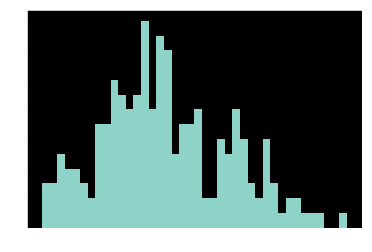

In [9]:
finalPhase = [ x_fire[i][-1] for i in range(N) ]
errors = np.array(finalPhase) - x_target
errors = np.mod(errors+np.pi,2*np.pi)-np.pi
plt.hist(errors,40)



(array([15., 16., 34., 44., 31., 18., 22., 12.,  6.,  2.]),
 array([-0.40251153, -0.30456532, -0.2066191 , -0.10867288, -0.01072666,
         0.08721956,  0.18516578,  0.283112  ,  0.38105822,  0.47900444,
         0.57695066]),
 <a list of 10 Patch objects>)

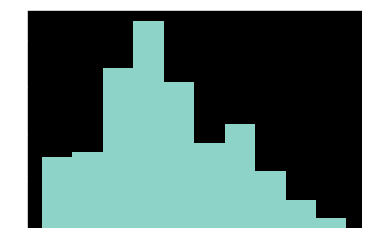

In [10]:
finalPhase = [ x_fire[i][-1] for i in range(N) ]
errors = np.array(finalPhase) - x_target
errors = np.mod(errors+np.pi,2*np.pi)-np.pi
plt.hist(errors)

